In [1]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import pandas as pd
import emcee
import corner

In [2]:
pwd


'/home/saurabhs/Documents/gopi/Saras_Model'

[0.7590379520559708, 0.7487805430072687, 0.738418897170908, 0.7279610891120162, 0.7174151898639791, 0.7067892617654515, 0.696091353951518, 0.6853294985296867, 0.6745117074710208, 0.6636459702464268, 0.6527402522379008, 0.6418024939544003, 0.6308406110819164, 0.6198624953972723, 0.6088760165750874, 0.5978890249172174, 0.5869093550336937, 0.5759448305036681, 0.5650032695439939, 0.5540924917116844, 0.5432203256643817, 0.5323946179999236, 0.5216232431917739, 0.5109141146311463, 0.5002751967786494, 0.4897145184176458, 0.4792401869876452, 0.4688604039581291, 0.4585834811803955, 0.4484178581262085, 0.4383721198861381, 0.4284550157561114, 0.4186754781864618, 0.4090426418021668, 0.3995658621244822, 0.3902547335314499, 0.3811191058866535, 0.372169099141552, 0.3634151150769697, 0.3548678451953959, 0.3465382736109212, 0.338437673613601, 0.3305775964185984, 0.3229698504601752, 0.3156264694735318, 0.3085596675454871, 0.3017817793346518, 0.2953051837936624, 0.2891422100028707, 0.2833050241781912, 0.2

70

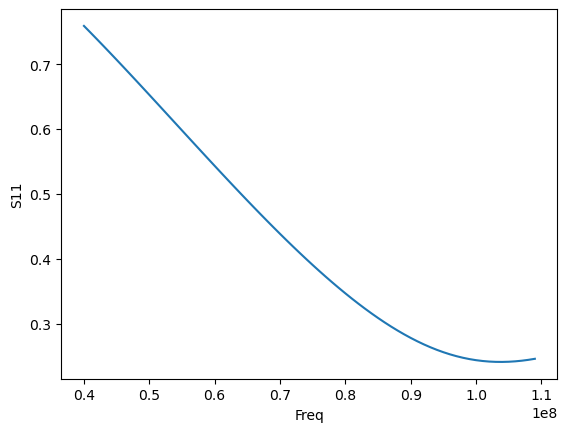

In [3]:
#Loading S11(RLC) and Frequency values
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_Model/saras3_S11_200mm_above_water.s1p", skiprows=5))
d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
v=[d[i][0] for i in range(len(d)-1)]

df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_Model/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()

print(rlc)
plt.plot(v,rlc)
plt.xlabel('Freq')
plt.ylabel('S11')
len(rlc)

In [4]:
def Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    freq= [d[i][0] for i in range(len(d))]
    for i in range(len(v)):
        gamma_A=p0*1e-48* freq[i] ** (N - 1) + p1*1e-39* freq[i] ** (N - 2) + p2*1e-31* freq[i] ** (N - 3) + p3*1e-23* freq[i] ** (N - 4) + p4*1e-15* freq[i] ** (N - 5) + p5*1e-08* freq[i] ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return Tmeas   

In [5]:
#Fixed Parameters
PA=300 
PN=70
gamma_N=0.3
f=0.1 
l =0.15
s=0.001
v=[d[i][0] for i in range(len(d)-1)]

## Estimation of RLC Parameters

In [6]:
########## Define the log-likelihood function
def log_likelihood(ip_params,params,**kwargs):

    PA = kwargs["PA"]
    PN = kwargs["PN"]
    gamma_N = kwargs["gamma_N"]
    f = kwargs["f"]
    l = kwargs["l"]
    #ip_params = args["ip_params"]
    s = kwargs["s"]
    seed=kwargs["seed"]
    v=kwargs["v"]

    #print(PA,ip_params)

    # Compute TA expected
    
    p0, p1, p2, p3, p4, p5, p6 = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    p0, p1, p2, p3, p4, p5, p6 = params
    TA_model = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 # - np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params,**kwargs):

    ## Define bounds for parameters
    #min_values = [ -6,  1, -5,  3.8, -2.5,  4.5,  4]
    #if type=='open' or type=='short':
    #max_values= [-5,  3, -4,  4.8, -1.8,  5.5,  5] 
    v=kwargs["v"]
    p0, p1, p2, p3, p4, p5, p6 = params
   
    #for i in range(len(v)):
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1):#np.all((gamma_A >= -1) & (gamma_A <= 1)):
        return 0.0  # Accept sample
    
    return -np.inf # Reject Sample
        
    
######### Define the full log-probability function
    
def log_probability(ip_params, params, **kwargs):
    lp = log_prior(params, **kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(ip_params, params, **kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_RLC(ip_params, nsteps, initial_value, **kwargs):
    
    # Define parameter names
    #args={"PA":PA, "PN":PN,  "gamma_N":gamma_N, "f":f, "l":l, "ip_params":ip_params, "s":s}
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    #args=args
    
    ## Number of walkers and steps
    
    ndim = 7  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=initial_value

    ## Starting positions for the walkers
    
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrapped_log_prob(params):
        return log_probability(ip_params, params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrapped_log_prob, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood(ip_params, p, **kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params
    
    


In [7]:
#evolve MCMC for RLC parameters
ip_params=[-6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73]

initials=[-6.10,  2.52, -4.34,  4.1, -2.06,  4.97,  4.55] 

nsteps=3000

seed=82
kwargs = {"PA":PA, "PN":PN, "gamma_N":gamma_N, "f":f, "l":l, "s":s, "v":v, "seed":seed}

full_samples, samples, best_fit_params_rlc= evolve_MCMC_RLC(ip_params,nsteps,initials,**kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [37:09<00:00,  1.35it/s]


In [ ]:
print("Acceptance fraction:", samples.acceptance_fraction)

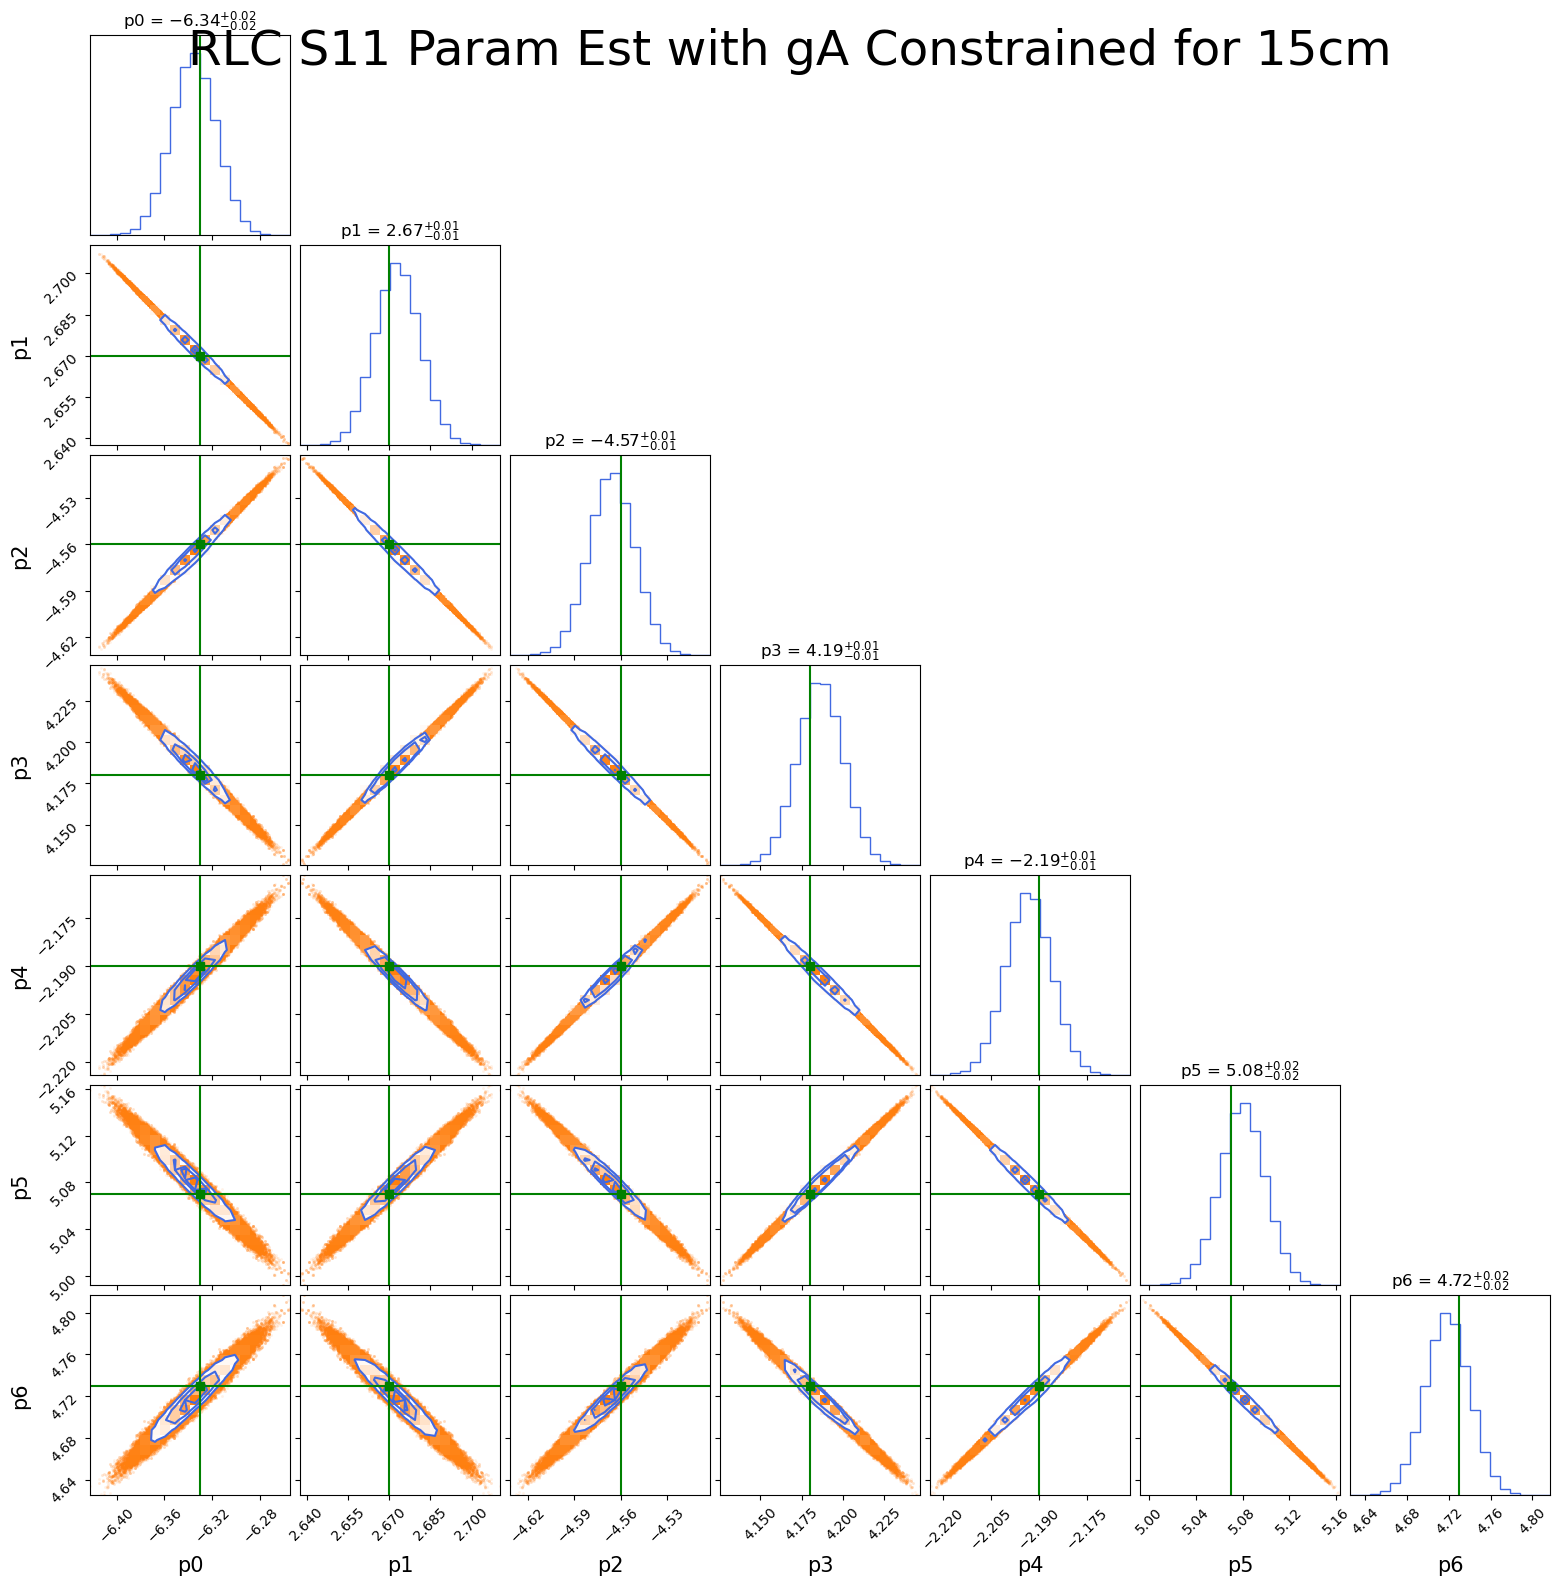

Best-fit parameters (Maximum Likelihood Estimate): [-6.33373978929451, 2.672023433321455, -4.56427413383693, 4.184577135294961, -2.1926425044779294, 5.077830291094332, 4.7206873515812005]


In [8]:
parameter_names = ["p0", "p1", "p2", "p3", "p4", "p5", "p6"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, show_titles=True, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("RLC S11 Param Est with gA Constrained for 15cm", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_S11_gA_15cm_2.png', dpi=300)

plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_rlc)

Text(0, 0.5, 'S11')

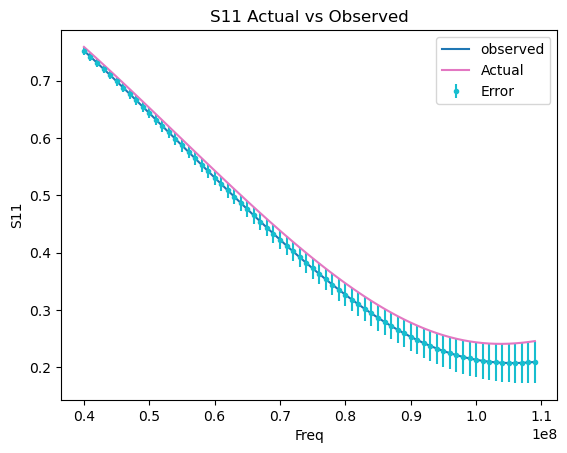

In [9]:
#Reconstructed S11 wrt best fit

p0, p1, p2, p3, p4, p5, p6=best_fit_params_rlc
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)
plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
#plt.plot(v,gamma_rlc, label='Obeserved')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.title("S11 Actual vs Observed")
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')

In [15]:
#computing S11 corresponding to all samples
reduced_samples_ = samples
S11_models_ = np.zeros((len(reduced_samples_), len(v)))

for ii in range(len(reduced_samples_)):
    p0, p1, p2, p3, p4, p5, p6= reduced_samples_[ii]
    S11_models_[ii]=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

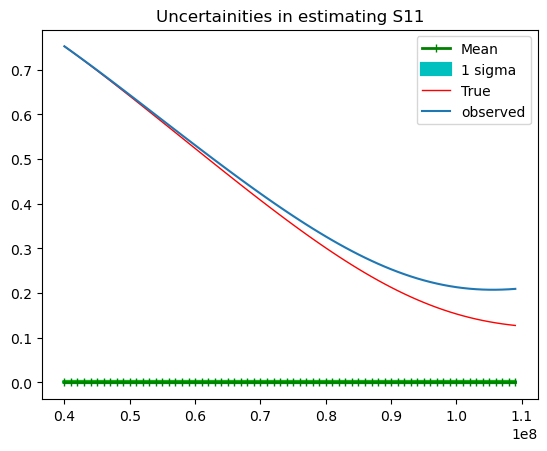

In [59]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
plt.plot(v, S11_models_[0::100].T, alpha=0.1, lw=1.5, color='y')

S11_mean = np.mean(S11_models_, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_,[16,84],axis=0)

plt.plot(v, S11_mean, lw=2, color='g', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='c', zorder=-1, lw=3, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]

gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
p0, p1, p2, p3, p4, p5, p6=best_fit_params_rlc
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gamma_A,label='observed')
plt.title("Uncertainities in estimating S11")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Uncertainity in TA estimation')

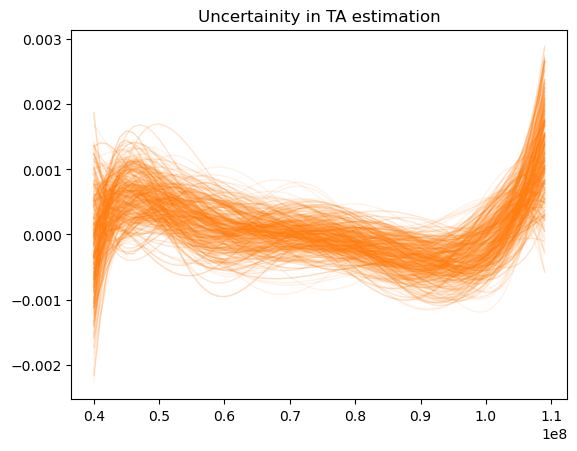

In [58]:
plt.figure()
#Reconstructing TA 
TA_exp=Compute_Tmeas_(300,-6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73,70,0.3,0.1,0.15)
for ii in range(len(reduced_samples_[::1000])):
    p0, p1, p2, p3, p4, p5, p6= reduced_samples_[ii]
    TA_obs=Compute_Tmeas_(300,p0,p1,p2,p3,p4,p5,p6,70,0.3,0.1,0.15)
    err=np.array(TA_obs)-np.array(TA_exp)
    plt.plot(v, err, color='C1',alpha=0.1, lw=1)
    

#plt.plot(v,TA_exp)
plt.title('Uncertainity in TA estimation')

In [46]:
print(len(reduced_samples_[::1000]))

500


## Full MCMC

In [27]:
########## Define the log-likelihood function
def log_likelihood_full(params,**kwargs):

    # Compute TA expected
    seed=kwargs["seed"]
    ip_params=kwargs["ip_params"]
    v=kwargs["v"]
    s=kwargs["s"]
    
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior_full(params, **kwargs):

    
    v=kwargs["v"]
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and 0<=gamma_N<=1):
        return 0.0  # Accept sample
    
    return -np.inf # Reject prior
        
    
######### Define the full log-probability function
    
def log_probability_full(params, **kwargs):
    lp = log_prior_full(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_Full(**kwargs):
    
    # Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    #args=args
    
    ## Number of walkers and steps
    
    ndim = 12  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=kwargs["initial_value"]

    ## Starting positions for the walkers (making sure that the initial positions satisfy the priors)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior_full(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    
    ## for making sure only positive positional values
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    
    def wrapped_log_prob_full(params):
        return log_probability_full(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrapped_log_prob_full, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood_full(p, **kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [28]:
#evolve MCMC full
ip_params=[300, -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73, 70, 0.3, 0.1, 0.15]
seed=3
p0, p1, p2, p3, p4, p5, p6= best_fit_params_rlc
initials=[300,p0, p1, p2, p3, p4, p5, p6, 70.1, 0.29, 0.099, 0.17]
nsteps=3000

kwargs = {"s":s, "v":v, "seed":seed, "nsteps":nsteps,"initial_value":initials, "ip_params":ip_params}

full_samples_full, samples_full, best_fit_params_full= evolve_MCMC_Full(**kwargs)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [42:40<00:00,  1.17it/s]


In [29]:
print(best_fit_params_full)

[299.9743890171012, -6.113567425454806, 2.65731423953403, -4.615934924826596, 4.263099363295154, -2.239982345920968, 5.237889796541252, 4.91893923460588, 70.10779097878583, 0.28957489237979545, 0.09260756954419819, 0.16747882945237316]


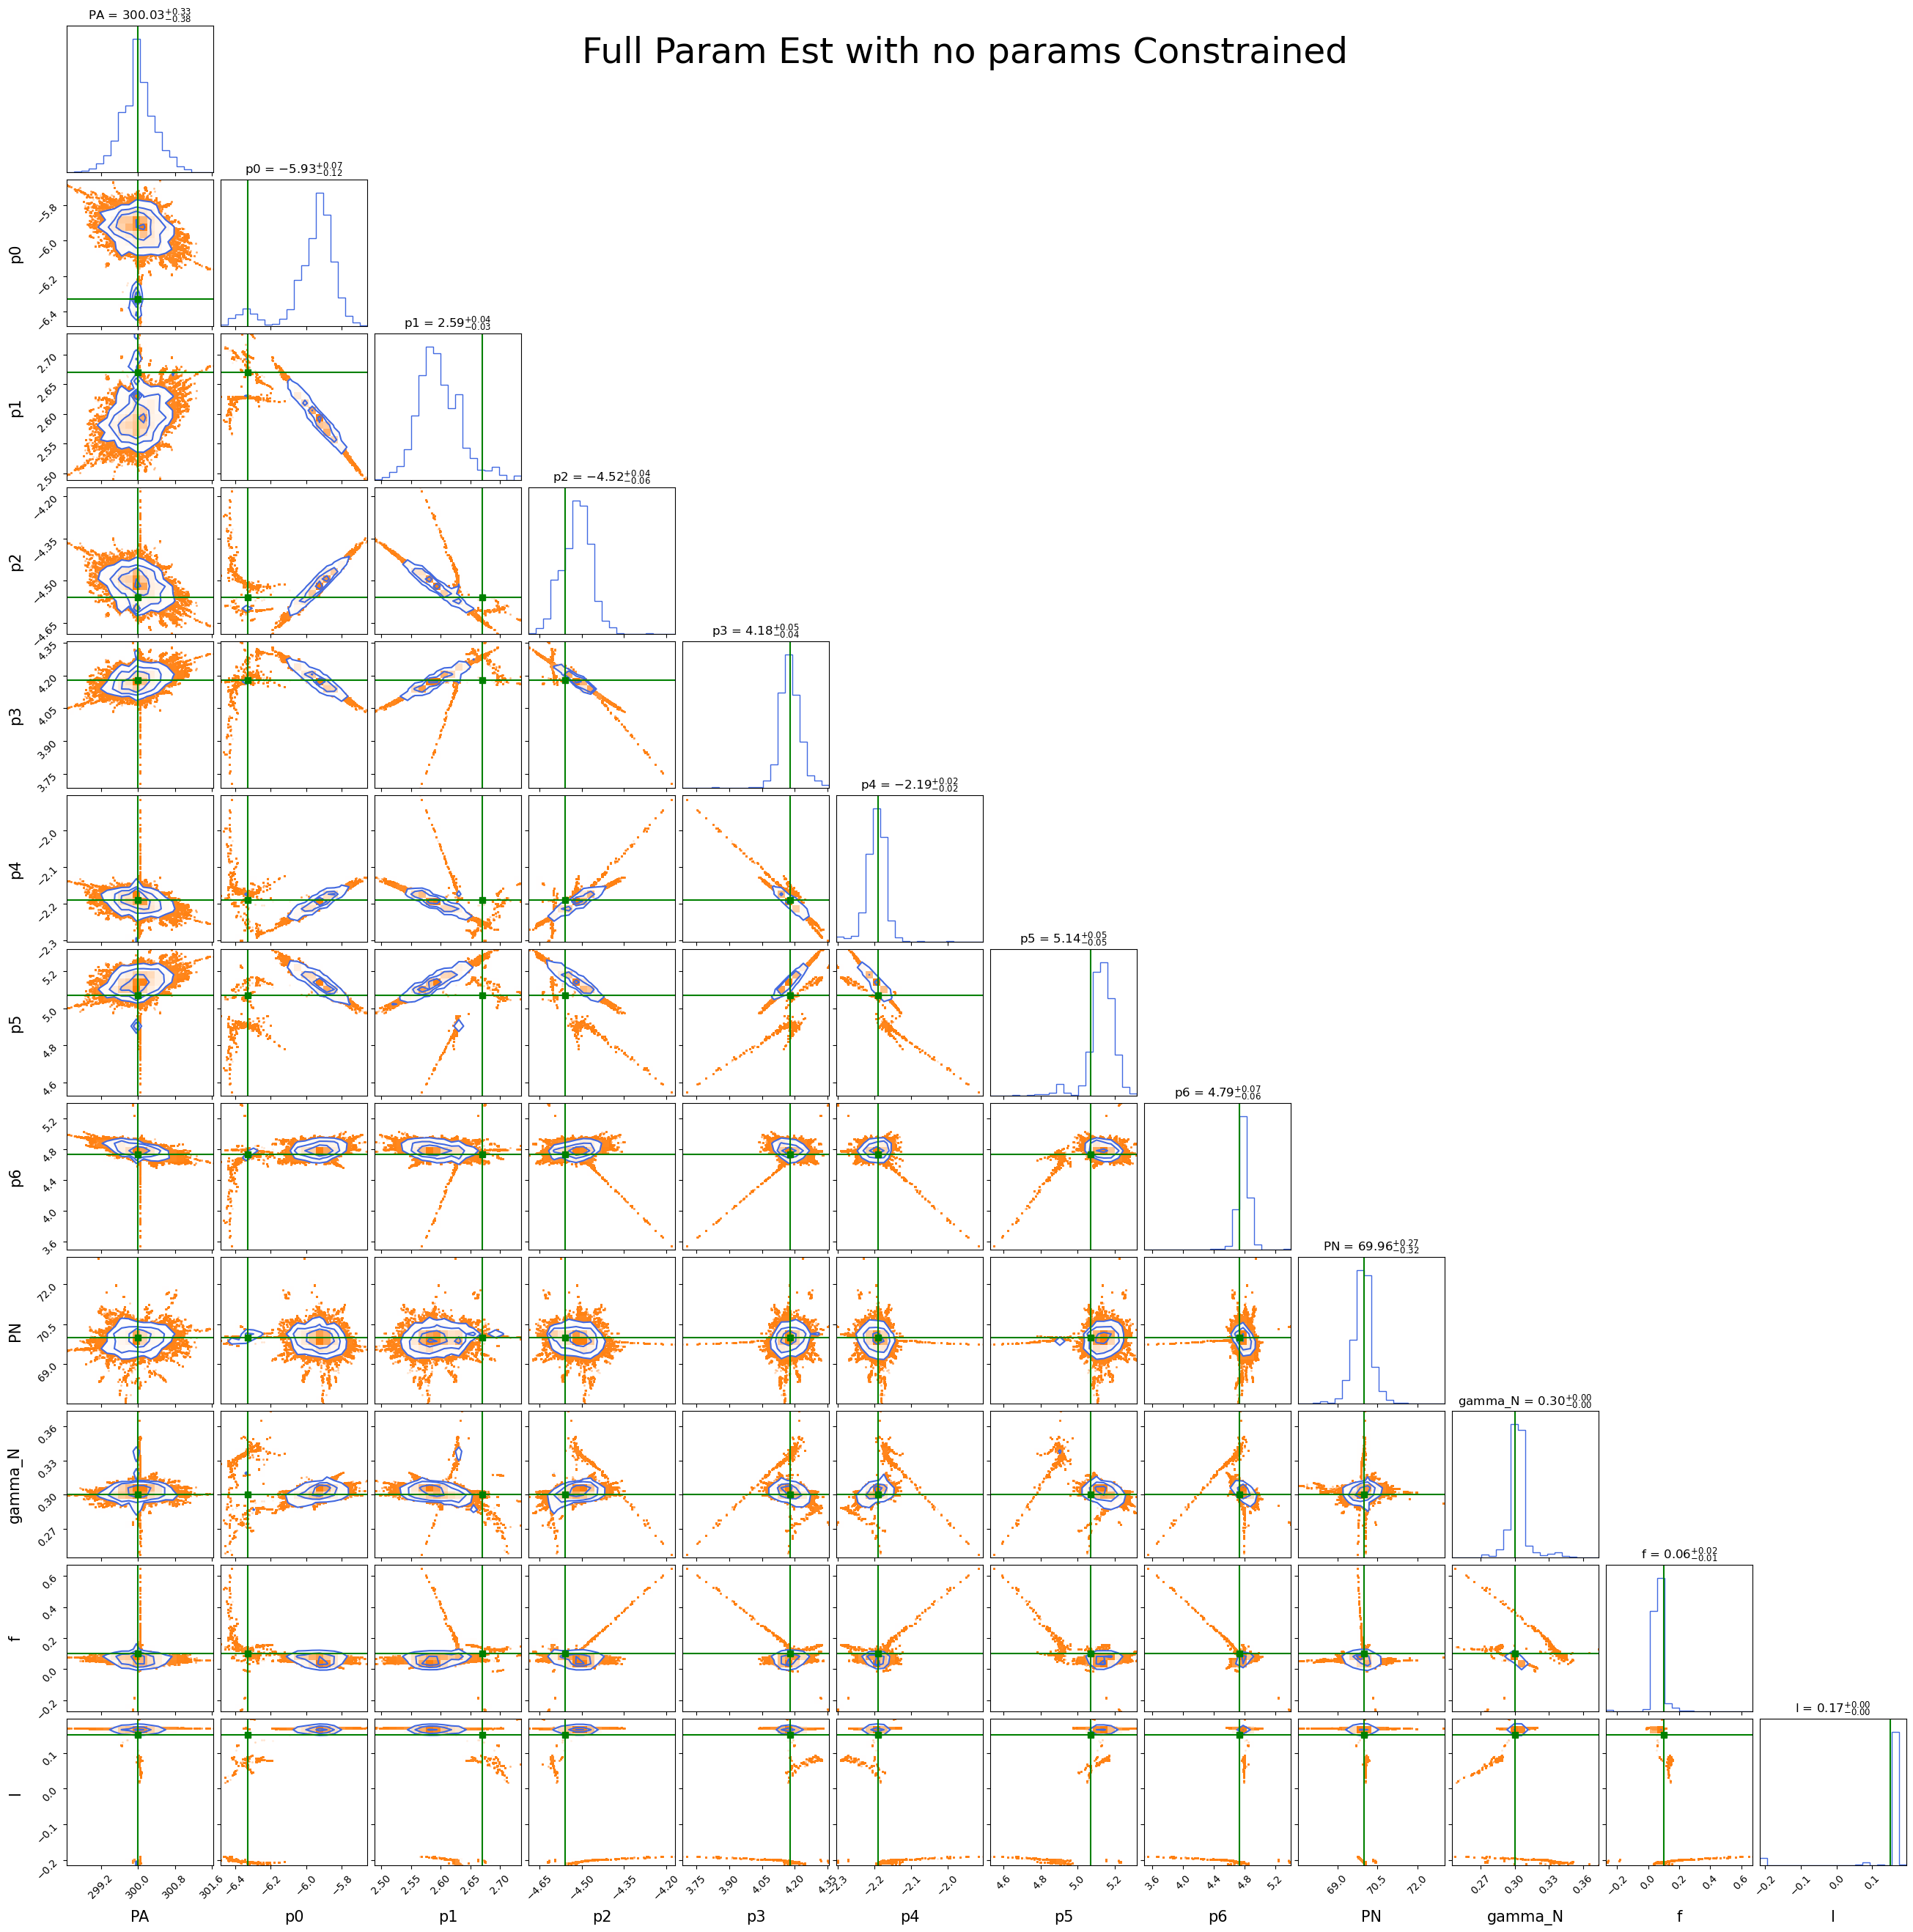

Best-fit parameters (Maximum Likelihood Estimate): [299.9743890171012, -6.113567425454806, 2.65731423953403, -4.615934924826596, 4.263099363295154, -2.239982345920968, 5.237889796541252, 4.91893923460588, 70.10779097878583, 0.28957489237979545, 0.09260756954419819, 0.16747882945237316]


In [31]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]
#corner plot 
fig = corner.corner(samples_full, labels=parameter_names, show_titles=True, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Full Param Est with no params Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_Full_gA_1m_.png', dpi=300)
#plt.savefig('Art.png')

plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_full)

In [32]:
#creating a CSV for storing the best fit parameters
data=[['PA','p0','p1','p2','p3','p4','p5','p6','PN','gN','f','l'],
      [round(i, 2) for i in ip_params],
      [round(p, 2) for p in best_fit_params_full]]
priors=["Priors: None  & seed: "+str(seed)]
sd=[str(seed)]
with open('Estimated params.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(priors)
    #writer.writerow(sd)
    writer.writerows(data)
    
print(seed)  

3


Text(0, 0.5, 'S11')

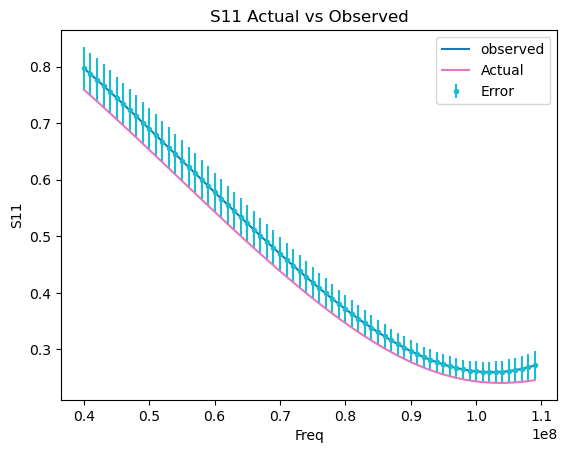

In [33]:
#Reconstructed S11 wrt best fit

PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_full
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
yerr=abs(rlc-gamma_A)
plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
#plt.plot(v,gamma_rlc, label='Obeserved')
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.title("S11 Actual vs Observed")
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')

In [36]:
#computing S11 corresponding to all samples
reduced_samples_full = samples_full
S11_models_full = np.zeros((len(reduced_samples_full), len(v)))

for ii in range(len(reduced_samples_)):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_full[ii]
    S11_models_full[ii]=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

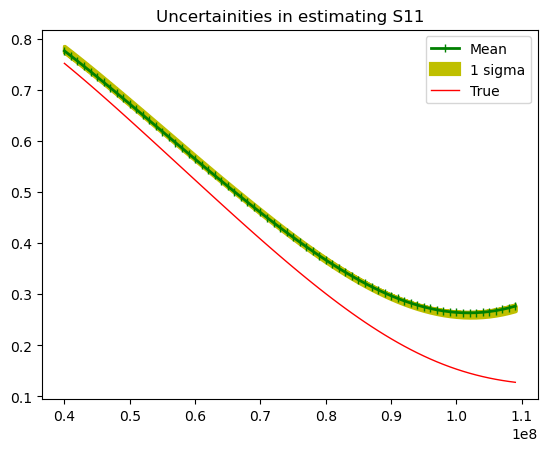

In [44]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
plt.plot(v, S11_models_full[0::100].T, alpha=0.1, lw=1.5, color='y')

S11_mean = np.mean(S11_models_full, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_full,[16,84],axis=0)

plt.plot(v, S11_mean, lw=2, color='g', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='y', zorder=-1, lw=3, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]

gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.title("Uncertainities in estimating S11")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Uncertainity in TA estimation')

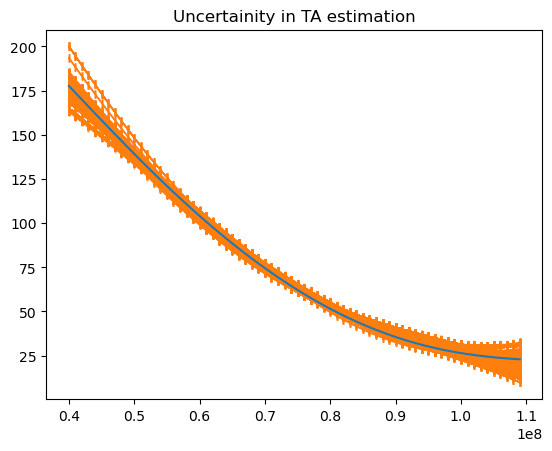

In [41]:
#Reconstructing TA 
for ii in range(len(reduced_samples_full)):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_full[ii]
    TA_obs=Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    plt.plot(v, TA_obs, color='C1', marker='|',alpha=0.1, lw=1)

TA_exp=Compute_Tmeas_(300,-6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73,70,0.3,0.1,0.15)
plt.plot(v,TA_exp)
plt.title('Uncertainity in TA estimation')

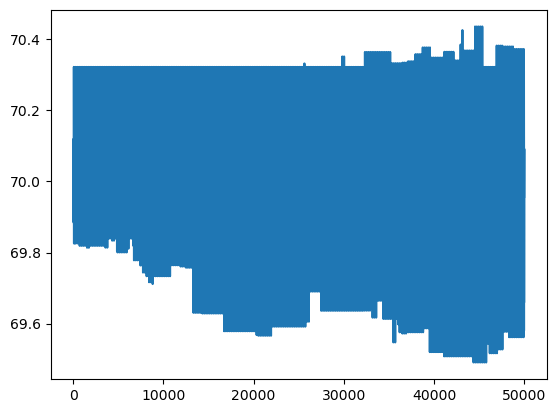

In [53]:
#checking other params
y=np.zeros(len(reduced_samples_full[::10]))
for ii in range(len(reduced_samples_full[::10])):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_full[ii]
    y[ii]=PN
x=np.arange(len(reduced_samples_full[::10]))
plt.plot(x,y)

In [ ]:
#Tmeas Obs vs Exp
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = best_fit_params_full
TA_obs=Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
ip_params=[300, -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73, 70, 0.3, 0.1, 1]
TA_exp=Compute_Tmeas_(*ip_params)

v=[d[i][0] for i in range(len(d)-1)]
plt.plot(v,TA_obs,label='Observed', color='C1',alpha=0.3, lw=6)
plt.plot(v,TA_exp,label='Expected', color='brown')
plt.legend()
plt.title('Freq vs TA for RLC')
#plt.savefig('/Users/gopipatel/Desktop/Comparision_plot_2m.png', dpi=300)

## RLC Coeffs as fixed parameters

In [ ]:
########## Define the log-likelihood function
def log_likelihood(ip_params,params,**kwargs):

    p0 = kwargs["p0"]
    p1 = kwargs["p1"]
    p2 = kwargs["p2"]
    p3 = kwargs["p3"]
    p4 = kwargs["p4"]
    p5 = kwargs["p5"]
    p6 = kwargs["p6"]
    s = kwargs["s"]

    #print(PA,ip_params)

    # Compute TA expected
    
    PA, PN, gamma_N, f, l = ip_params
    
    np.random.seed(3)
    TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior(params):

    ## Define bounds for parameters
    #min_values = [ -6,  1, -5,  3.8, -2.5,  4.5,  4]
    #if type=='open' or type=='short':
    #max_values= [-5,  3, -4,  4.8, -1.8,  5.5,  5] 
    """
    p0, p1, p2, p3, p4, p5, p6 = params
    N=7
    gamma_rlc=[]
    for i in range(len(v)):
        
        gamma_value = (p0 * v[i] ** (N - 1) + 
                   p1 * v[i] ** (N - 2) + 
                   p2 * v[i] ** (N - 3) + 
                   p3 * v[i] ** (N - 4) + 
                   p4 * v[i] ** (N - 5) + 
                   p5 * v[i] ** (N - 6) + 
                   p6)
        if not (-1 <= gamma_value <= 1):
            return -np.inf  # Reject sample
        
        gamma_rlc.append(gamma_value)
        
    
    
    #for p, min_v, max_v in zip(params, min_values, max_values):
        #if not (min_v <= p <= max_v):
            #return -np.inf  # Reject sample
    """
    return 0.0  # Uniform prior
    
######### Define the full log-probability function
    
def log_probability(ip_params, params, **kwargs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(ip_params, params, **kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_RLC(ip_params, nsteps, initial_value, **kwargs):
    
    # Define parameter names
    #args={"PA":PA, "PN":PN,  "gamma_N":gamma_N, "f":f, "l":l, "ip_params":ip_params, "s":s}
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    #args=args
    
    ## Number of walkers and steps
    
    ndim = 5  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=initial_value

    ## Starting positions for the walkers
    
    pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    """
    ## for making sure only positive positional values
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    def wrapped_log_prob(params):
        return log_probability(ip_params, params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrapped_log_prob, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood(ip_params, p, **kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [ ]:
#evolve MCMC for system parameters
ip_params=[300,  70.0, 0.3,  0.1, 1]

initials=[301, 70.1, 0.29, 0.099, 1.9] 

nsteps=3000

p0, p1, p2, p3, p4, p5, p6=[-6.288966134744889, 2.6520672255189663, -4.528177118557255, 4.1407465556243945, -2.1713599677905244, 5.0323002606113505, 4.768990462310462]
kwargs = {"p0":p0, "p1":p1, "p2":p2, "p3":p3, "p4":p4, "p5":p5, "p6":p6, "s":s}

full_samples, samples, best_fit_params= evolve_MCMC_RLC(ip_params,nsteps,initials,**kwargs)

In [ ]:
parameter_names = ["PA", "PN", "gamma_N", "f", "l"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
#plt.savefig('/Users/gopipatel/Desktop/RLC_1m.png', dpi=300)
#plt.savefig('Art.png')

plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params)

## Extras

In [ ]:
'''
#selecting only the indices where the S11 is less than 1 wrt frequency
ind_select = (np.amax(S11_models, axis=1)<=1)
prior_samples_1 = S11_models[ind_select]
good_values=reduced_samples[ind_select]

#indices where gamma is greater than 1
bad_ind_select = (np.amax(S11_models, axis=1)>=1)
bad_S11_samples_1 = S11_models[bad_ind_select]
bad_values=reduced_samples[bad_ind_select]

print(bad_S11_samples_1.shape)
'''

In [ ]:
'''
one_sigma_samples=[]
for i in range(7):
    one_sigma=np.percentile(samples[:,i], [16,84])
    indices_within_one_sigma = np.logical_and((samples[:,i] >= one_sigma[0]),\
    (samples[:,i] <= one_sigma[1]))
    #one_sigma_mu.append(one_sigma)
    one_sigma_samples.append(samples[indices_within_one_sigma,:])
#np.percentile(samples_all[:,0], [16, 84])
print(one_sigma_samples[:][5][19])
po,p1,p2,p3,p4,p5,p6=one_sigma_samples[:][5][19]
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gamma_A,'tab:blue', label='Obs')
plt.plot(v,rlc,'tab:pink', label='Actual')
'''

In [ ]:
'''#S11 Uncertainity
v=[d[i][0] for i in range(len(d)-1)]
for i in range(7):#len(one_sigma_samples)):
    
    for j in range(5000):#len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        po,p1,p2,p3,p4,p5,p6=one_sigma_samples[:][i][j]
        #print(one_sigma_samples[:][i][j])
        gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
        #print(max(gamma_A))
        #yerr=abs(rlc-gamma_A)
        #plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
        plt.plot(v, gamma_A,color='C1',alpha=0.1, lw=1)
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
#plt.ylim(0,1)'''

In [ ]:
'''
#Uncertainity in TA 
TA_exp=Compute_Tmeas_(300,-6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73,70,0.3,0.1,1)
for i in range(7):
    for j in range(1000):
        #len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        po,p1,p2,p3,p4,p5,p6=one_sigma_samples[:][i][j]
        TA_obs=Compute_Tmeas_(300,p0,p1,p2,p3,p4,p5,p6,70,0.3,0.1,1)
        plt.plot(v, TA_obs,color='C1',alpha=0.1, lw=1)
plt.plot(v,TA_exp,'r', label='Actual TA')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA')
plt.title("TA Exp vs Obs")
plt.legend()
'''

In [ ]:
'''
one_sigma_samples_full=[]
for i in range(12):
    one_sigma_full=np.percentile(samples[:,i], [16,84])
    indices_within_one_sigma_full = np.logical_and((samples[:,i] >= one_sigma_full[0]),\
    (samples[:,i] <= one_sigma_full[1]))
    #one_sigma_mu.append(one_sigma)
    one_sigma_samples_full.append(samples[indices_within_one_sigma_full,:])
#np.percentile(samples_all[:,0], [16, 84])
print(len(one_sigma_samples_full[:][5][100]))
#S11 Uncertainity
v=[d[i][0] for i in range(len(d)-1)]
for i in range(12):#len(one_sigma_samples)):
    
    for j in range(1000):#len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        PA, po,p1,p2,p3,p4,p5,p6, pN,gN, f,l=one_sigma_samples_full[:][i][j]
        #print(one_sigma_samples[:][i][j])
        gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
        #print(max(gamma_A))
        #yerr=abs(rlc-gamma_A)
        #plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
        plt.plot(v, gamma_A,color='C1',alpha=0.1, lw=1)
plt.plot(v,rlc,'tab:pink', label='Actual')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')
plt.title('S11 Obs vs Exp')
plt.ylim(0,1) 
'''

In [ ]:
'''#Uncertainity in TA 
TA_exp=Compute_Tmeas_(300,-6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73,70,0.3,0.1,0.15)
for i in range(7):
    for j in range(1000):
        #len(one_sigma_samples[100]:#[::100]:#len(one_sigma_samples)):
        #print(i,j)
        PA,po,p1,p2,p3,p4,p5,p6,PN,gN,f,l=one_sigma_samples_full[:][i][j]
        TA_obs=Compute_Tmeas_(PA,po,p1,p2,p3,p4,p5,p6,PN,gN,f,l)
        plt.plot(v, TA_obs,color='C1',alpha=0.1, lw=1)
plt.plot(v,TA_exp,'r', label='Actual TA')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA')
plt.title("TA Exp vs Obs")
plt.legend()'''